# Result analysis of national SIRDS simulations

In [47]:
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mticker
import util
from PIL import Image
from sirds_model_visualization import get_sirds, get_sirds_extras, show_performance, plot_result, plot_parameters, \
    plot_fuzzy_variables, calculate_performance

## Reading data

In [48]:
df_covid_brazil = pd.read_csv('data/output/df_ts_epidemic_episodes.csv')
df_covid_brazil.DATA = pd.to_datetime(df_covid_brazil.DATA, infer_datetime_format=True)
df_covid_brazil['TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL'] = df_covid_brazil.CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL / df_covid_brazil.POPULACAO_2022 * 100000

In [49]:
df_covid_other_countries = pd.read_csv('data/output/df_ts_epidemic_episodes_other_countries.csv')
df_covid_other_countries.date = pd.to_datetime(df_covid_other_countries.date)

In [50]:
df_fitting_recovery_period_brazil = pd.read_csv('data/output/fitting_recovery_period_results.csv')

In [51]:
df_fitting_other_countries = pd.read_csv('data/output/execution_other_countries_results.csv')

In [52]:
df_fitting_other_countries.location.unique()

array(['United States', 'Spain', 'United Kingdom'], dtype=object)

## Show results

### Figure 6

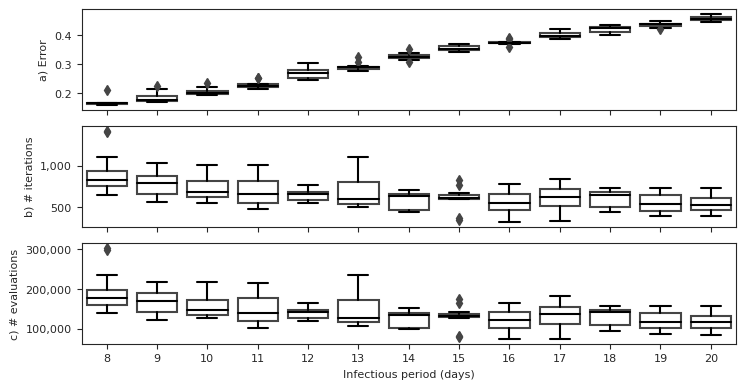

In [53]:
sns.set_style("ticks")
sns.set_palette("gray")
plt.rc('font', size=8)

fig, ax = plt.subplots(3, 1, figsize=(util.centimeter_to_inch(19.05), util.centimeter_to_inch(10)), sharex=True)

sns.boxplot(x=df_fitting_recovery_period_brazil.days_to_recovery.astype(int), y=df_fitting_recovery_period_brazil.result_fun, boxprops=dict(facecolor='white'), ax=ax[0])
ax[0].set_ylabel('a) Error')      
ax[0].set_xlabel(None)
plt.setp(ax[0].artists, edgecolor = 'black')
plt.setp(ax[0].lines, color='black')

sns.boxplot(x=df_fitting_recovery_period_brazil.days_to_recovery.astype(int), y=df_fitting_recovery_period_brazil.result_nit, boxprops=dict(facecolor='white'), ax=ax[1])
ax[1].set_ylabel('b) # iterations')      
ax[1].set_xlabel(None)
plt.setp(ax[1].artists, edgecolor = 'black')
plt.setp(ax[1].lines, color='black')
ax[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))

sns.boxplot(x=df_fitting_recovery_period_brazil.days_to_recovery.astype(int), y=df_fitting_recovery_period_brazil.result_nfev, boxprops=dict(facecolor='white'), ax=ax[2])
ax[2].set_ylabel('c) # evaluations')      
ax[2].set_xlabel(None)
plt.setp(ax[2].artists, edgecolor = 'black')
plt.setp(ax[2].lines, color='black')
ax[2].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax[2].set_xlabel('Infectious period (days)')

plt.tight_layout()

plt.savefig('images/boxplot_sirds_optimization.pdf', bbox_inches="tight")
plt.savefig('images/boxplot_sirds_optimization.tiff', format='tiff', dpi=300, transparent=False, bbox_inches='tight')
img = Image.open("images/boxplot_sirds_optimization.tiff")
img.save("images/boxplot_sirds_optimization_compressed.tiff", compression="tiff_lzw")
plt.show()

### Figure 7

In [54]:
df_prevalence_analysis_simulation = pd.DataFrame()
df_prevalence_analysis_real = pd.DataFrame()

### Brazil

mae_fit :  0.16773103328657954 ( 0.1623699633888317 , 0.1766242195874814 )
sse_D_fit :  0.004042601031263582 ( 0.0037699569862469705 , 0.004296325912503518 )
r2_D_fit :  0.9663944821775873 ( 0.9636457577016855 , 0.9689907283030922 )
sse_Rt_fit :  0.009629703881370723 ( 0.007797050143637624 , 0.012977824203022811 )
r2_Rt_fit :  0.8637364701159648 ( 0.8163939255765094 , 0.8895676110224354 )


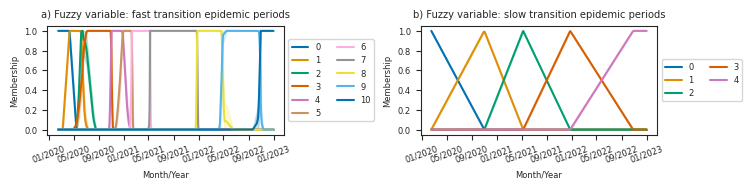

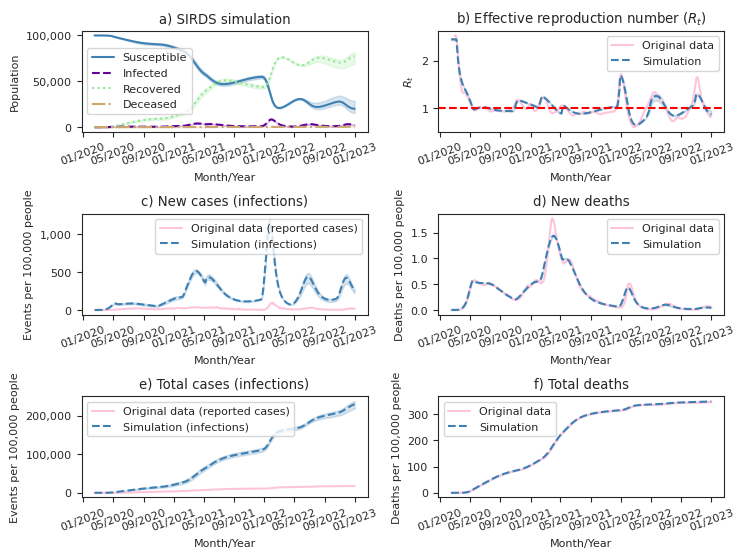

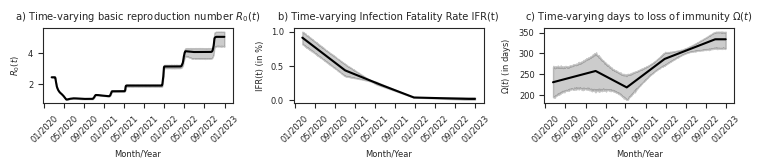

In [55]:
days_to_recovery = 8

df_results = df_fitting_recovery_period_brazil[df_fitting_recovery_period_brazil.days_to_recovery == days_to_recovery]
date_first_case = pd.to_datetime(df_results.date_first_case.unique()[0])
df_covid_brazil = df_covid_brazil[df_covid_brazil.DATA >= date_first_case]

real_reproduction_number = df_covid_brazil.NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA.values
real_new_deaths = df_covid_brazil.TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_SIM.values
real_total_deaths = df_covid_brazil.TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_SIM.cumsum().values
real_new_cases = df_covid_brazil.TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL.values
real_total_cases = df_covid_brazil.TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL.cumsum().values

df_S = pd.DataFrame()
df_I = pd.DataFrame()
df_R = pd.DataFrame()
df_D = pd.DataFrame()
df_I_accumulated = pd.DataFrame()
df_new_deaths = pd.DataFrame()
df_rt = pd.DataFrame()
df_new_cases = pd.DataFrame()
df_r0 = pd.DataFrame()
df_IFR = pd.DataFrame()
df_Omega = pd.DataFrame()
list_fuzzy_fast_transition = []
list_fuzzy_slow_transition = []

dict_performance = {'mae_fit': [], 'sse_D_fit': [], 'r2_D_fit': [], 'sse_Rt_fit': [], 'r2_Rt_fit': []} 

for index, result in df_results.iterrows():    
    y = get_sirds(result)
    S, I, R, D, I_accumulated = y
    min_length = min(len(real_new_deaths), len(D))
    S = S[:min_length]
    I = I[:min_length]
    R = R[:min_length]
    D = D[:min_length]
    I_accumulated = I_accumulated[:min_length]
    N = S[0] + I[0] + R[0] + D[0]
    
    dates = df_covid_brazil[:min_length].DATA.values
    
    D_new_deaths, reproduction_number_sird, I_new_cases, epidemic_periods_with_fast_transition_fuzzy_variable, epidemic_periods_with_slow_transition_fuzzy_variable, days_between_infections_values, case_fatality_probability_values, loss_immunity_in_days_values, estimated_days_between_infections, estimated_case_fatality_probability, estimated_loss_immunity_in_days = get_sirds_extras(result, S, D, I_accumulated)
    
    df_S_temp = pd.DataFrame({'date': dates, 'S': S})
    df_I_temp = pd.DataFrame({'date': dates, 'I': I})
    df_R_temp = pd.DataFrame({'date': dates, 'R': R})
    df_D_temp = pd.DataFrame({'date': dates, 'D': D})
    df_I_accumulated_temp = pd.DataFrame({'date': dates, 'I_accumulated': I_accumulated})
    df_new_deaths_temp = pd.DataFrame({'date': dates[1:], 'deaths': D_new_deaths})
    df_rt_temp = pd.DataFrame({'date': dates, 'rt': reproduction_number_sird})
    df_new_cases_temp = pd.DataFrame({'date': dates[1:], 'cases': I_new_cases})
    df_r0_temp = pd.DataFrame({'date': dates, 'r0': days_to_recovery/estimated_days_between_infections}) 
    df_IRF_temp = pd.DataFrame({'date': dates, 'ifr': estimated_case_fatality_probability})
    df_Omega_temp = pd.DataFrame({'date': dates, 'Omega': estimated_loss_immunity_in_days})
               
    df_S = pd.concat([df_S, df_S_temp])
    df_I = pd.concat([df_I, df_I_temp])
    df_R = pd.concat([df_R, df_R_temp])
    df_D = pd.concat([df_D, df_D_temp])
    df_I_accumulated = pd.concat([df_I_accumulated, df_I_accumulated_temp])
    df_new_deaths = pd.concat([df_new_deaths, df_new_deaths_temp])
    df_rt = pd.concat([df_rt, df_rt_temp])
    df_new_cases = pd.concat([df_new_cases, df_new_cases_temp])
    df_r0 = pd.concat([df_r0, df_r0_temp])
    df_IFR = pd.concat([df_IFR, df_IRF_temp])
    df_Omega = pd.concat([df_Omega, df_Omega_temp])
    list_fuzzy_fast_transition.append(epidemic_periods_with_fast_transition_fuzzy_variable)
    list_fuzzy_slow_transition.append(epidemic_periods_with_slow_transition_fuzzy_variable)
    
    mae_fit, sse_D_fit, r2_D_fit, sse_Rt_fit, r2_Rt_fit = calculate_performance(real_new_deaths, D_new_deaths, real_reproduction_number,  reproduction_number_sird)
    dict_performance['mae_fit'].append(mae_fit)
    dict_performance['sse_D_fit'].append(sse_D_fit)
    dict_performance['r2_D_fit'].append(r2_D_fit)
    dict_performance['sse_Rt_fit'].append(sse_Rt_fit)
    dict_performance['r2_Rt_fit'].append(r2_Rt_fit)   

last_prevalence_study_brazil = pd.to_datetime('2020-06-07') + pd.DateOffset(days=0)
df_prevalence_analysis_simulation_temp = df_I_accumulated[df_I_accumulated.date <= last_prevalence_study_brazil].copy()
df_prevalence_analysis_simulation_temp['country'] = 'Brazil'
df_prevalence_analysis_simulation = pd.concat([df_prevalence_analysis_simulation, df_prevalence_analysis_simulation_temp])

df_prevalence_analysis_real_temp = df_covid_brazil[df_covid_brazil.DATA <= last_prevalence_study_brazil][['DATA', 'TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL']].copy()
df_prevalence_analysis_real_temp = df_prevalence_analysis_real_temp.rename(columns={'DATA': 'date', 'TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL': 'rate_new_cases_moving_average'})
df_prevalence_analysis_real_temp['rate_new_cases_moving_average'] = df_prevalence_analysis_real_temp['rate_new_cases_moving_average'].cumsum() 
df_prevalence_analysis_real_temp['country'] = 'Brazil'
df_prevalence_analysis_real = pd.concat([df_prevalence_analysis_real, df_prevalence_analysis_real_temp])

show_performance(dict_performance)

plot_fuzzy_variables(dates, list_fuzzy_fast_transition, list_fuzzy_slow_transition, 'brazil')     

plot_result(df_S, df_I, df_R, df_D, df_new_deaths, df_I_accumulated, real_new_deaths[:min_length], real_total_deaths[:min_length], real_reproduction_number[:min_length], df_rt, real_total_cases[:min_length], real_new_cases[:min_length], df_new_cases, df_covid_brazil[:min_length].DATA.values, epidemic_periods_with_fast_transition_fuzzy_variable, epidemic_periods_with_slow_transition_fuzzy_variable, id_in_file='brazil')

plot_parameters(df_r0, df_IFR, df_Omega, 'brazil')

### Other countries

United States
mae_fit :  0.15918120999145455 ( 0.15687140930870663 , 0.16123603863822866 )
sse_D_fit :  0.0014502971195398434 ( 0.001384478864937383 , 0.0015235187814511492 )
r2_D_fit :  0.9730893286709735 ( 0.9717557832141654 , 0.9744469050257156 )
sse_Rt_fit :  0.010090557890548416 ( 0.009631520138055419 , 0.010634973903250956 )
r2_Rt_fit :  0.8410925356535175 ( 0.8330720322237525 , 0.8485129198293608 )


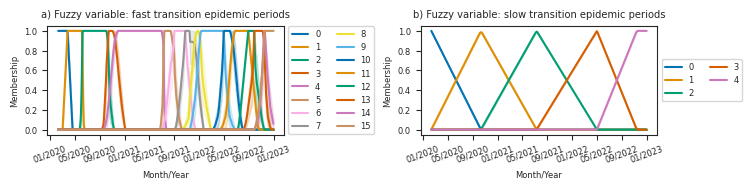

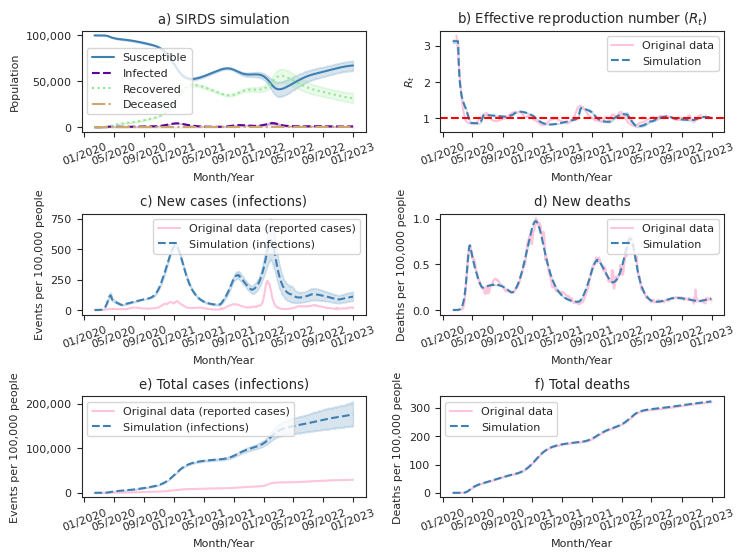

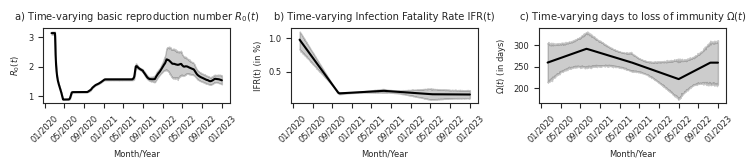

Spain
mae_fit :  0.3231951850662879 ( 0.31671592166280144 , 0.3296089013851628 )
sse_D_fit :  0.006121084473227047 ( 0.005776772334244463 , 0.006485987433748779 )
r2_D_fit :  0.9184888934723465 ( 0.9131566648192034 , 0.9232694296139192 )
sse_Rt_fit :  0.039025556753658645 ( 0.03741195740136606 , 0.04051823266798077 )
r2_Rt_fit :  0.7509086292835774 ( 0.7408055421073269 , 0.7598987416849534 )


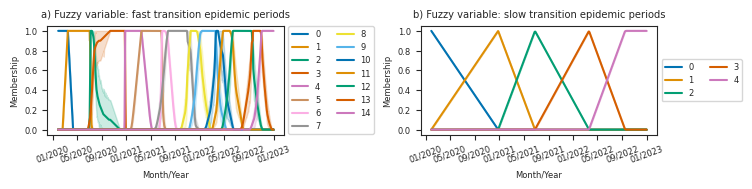

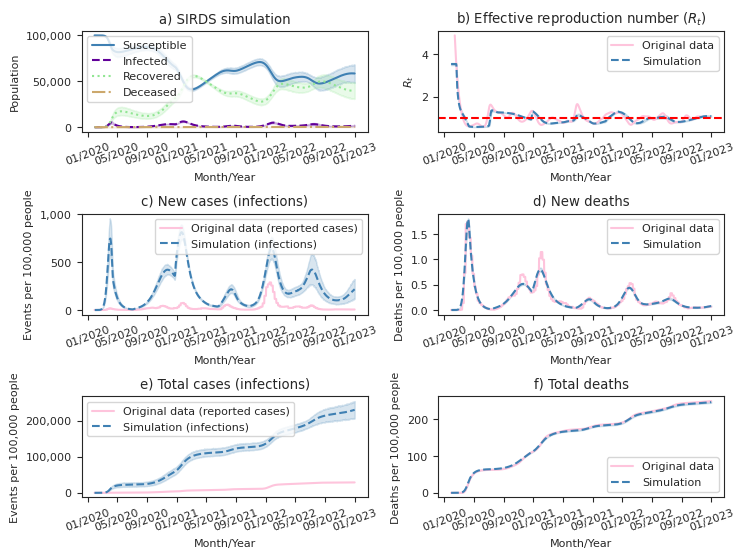

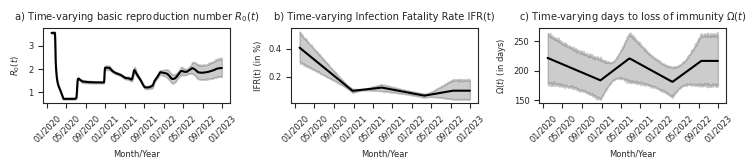

United Kingdom
mae_fit :  0.2236684923243694 ( 0.21993244790785532 , 0.2270801984524811 )
sse_D_fit :  0.002807666817015524 ( 0.002673266677965051 , 0.0029268842989130907 )
r2_D_fit :  0.9839642370368964 ( 0.9833000051158312 , 0.9847247363367477 )
sse_Rt_fit :  0.02329415836352685 ( 0.022087542539285993 , 0.024492399179318086 )
r2_Rt_fit :  0.8860211920932513 ( 0.8798749672158255 , 0.8921079055513339 )


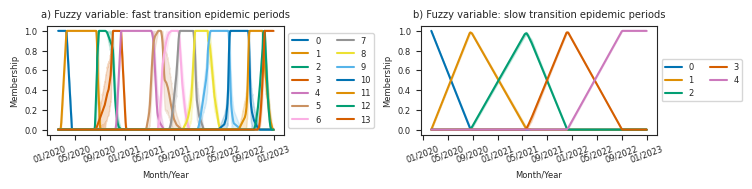

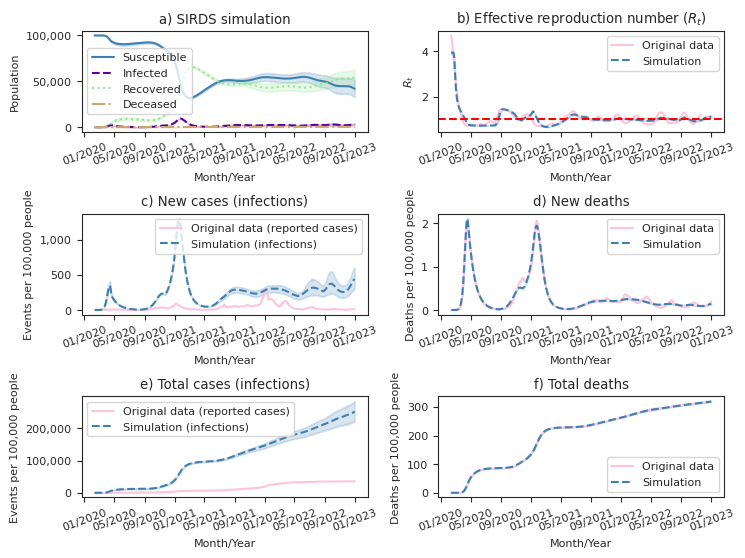

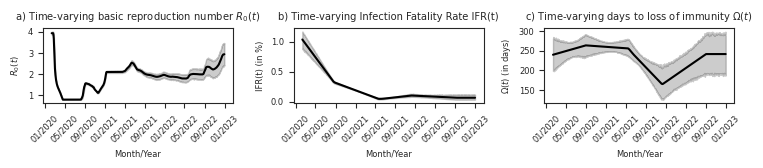

In [56]:
dict_last_prevalence_study = {'Spain': pd.to_datetime('2020-06-22'), 'United Kingdom': pd.to_datetime('2020-09-18'), 'United States': pd.to_datetime('2020-07-31')}

for country in df_fitting_other_countries.location.unique():
    print(country)
    df_results = df_fitting_other_countries[df_fitting_other_countries.location == country]
    date_first_case = pd.to_datetime(df_results.date_first_case.unique()[0])
    
    df_covid_country = df_covid_other_countries[(df_covid_other_countries.location == country) & (df_covid_other_countries.date >= date_first_case)]
    real_reproduction_number = df_covid_country.NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIA.values
    real_new_deaths = df_covid_country.rate_new_deaths_moving_average.values
    real_total_deaths = df_covid_country.rate_new_deaths_moving_average.cumsum().values
    real_new_cases = df_covid_country.rate_new_cases_moving_average.values
    real_total_cases = df_covid_country.rate_new_cases_moving_average.cumsum().values
        
    df_S = pd.DataFrame()
    df_I = pd.DataFrame()
    df_R = pd.DataFrame()
    df_D = pd.DataFrame()
    df_I_accumulated = pd.DataFrame()
    df_new_deaths = pd.DataFrame()
    df_rt = pd.DataFrame()
    df_new_cases = pd.DataFrame()
    df_r0 = pd.DataFrame()
    df_IFR = pd.DataFrame()
    df_Omega = pd.DataFrame()
    list_fuzzy_fast_transition = []
    list_fuzzy_slow_transition = []
    
    dict_performance = {'mae_fit': [], 'sse_D_fit': [], 'r2_D_fit': [], 'sse_Rt_fit': [], 'r2_Rt_fit': []}
    
    for index, result in df_results.iterrows():
        result = result.dropna()
        
        y = get_sirds(result)
        S, I, R, D, I_accumulated = y
        min_length = min(len(real_new_deaths), len(D))
        S = S[:min_length]
        I = I[:min_length]
        R = R[:min_length]
        D = D[:min_length]
        I_accumulated = I_accumulated[:min_length]
        N = S[0] + I[0] + R[0] + D[0]
        
        dates = df_covid_country[:min_length].date.values
        
        D_new_deaths, reproduction_number_sird, I_new_cases, epidemic_periods_with_fast_transition_fuzzy_variable, epidemic_periods_with_slow_transition_fuzzy_variable, days_between_infections_values, case_fatality_probability_values, loss_immunity_in_days_values, estimated_days_between_infections, estimated_case_fatality_probability, estimated_loss_immunity_in_days = get_sirds_extras(result, S, D, I_accumulated)
        
        df_S_temp = pd.DataFrame({'date': dates, 'S': S})
        df_I_temp = pd.DataFrame({'date': dates, 'I': I})
        df_R_temp = pd.DataFrame({'date': dates, 'R': R})
        df_D_temp = pd.DataFrame({'date': dates, 'D': D})
        df_I_accumulated_temp = pd.DataFrame({'date': dates, 'I_accumulated': I_accumulated})
        df_new_deaths_temp = pd.DataFrame({'date': dates[1:], 'deaths': D_new_deaths})
        df_rt_temp = pd.DataFrame({'date': dates, 'rt': reproduction_number_sird})
        df_new_cases_temp = pd.DataFrame({'date': dates[1:], 'cases': I_new_cases})
        df_r0_temp = pd.DataFrame({'date': dates, 'r0': days_to_recovery/estimated_days_between_infections}) 
        df_IRF_temp = pd.DataFrame({'date': dates, 'ifr': estimated_case_fatality_probability})
        df_Omega_temp = pd.DataFrame({'date': dates, 'Omega': estimated_loss_immunity_in_days})
                   
        df_S = pd.concat([df_S, df_S_temp])
        df_I = pd.concat([df_I, df_I_temp])
        df_R = pd.concat([df_R, df_R_temp])
        df_D = pd.concat([df_D, df_D_temp])
        df_I_accumulated = pd.concat([df_I_accumulated, df_I_accumulated_temp])
        df_new_deaths = pd.concat([df_new_deaths, df_new_deaths_temp])
        df_rt = pd.concat([df_rt, df_rt_temp])
        df_new_cases = pd.concat([df_new_cases, df_new_cases_temp])
        df_r0 = pd.concat([df_r0, df_r0_temp])
        df_IFR = pd.concat([df_IFR, df_IRF_temp])
        df_Omega = pd.concat([df_Omega, df_Omega_temp])
        list_fuzzy_fast_transition.append(epidemic_periods_with_fast_transition_fuzzy_variable)
        list_fuzzy_slow_transition.append(epidemic_periods_with_slow_transition_fuzzy_variable)
        
        mae_fit, sse_D_fit, r2_D_fit, sse_Rt_fit, r2_Rt_fit = calculate_performance(real_new_deaths, D_new_deaths, real_reproduction_number,  reproduction_number_sird)
        dict_performance['mae_fit'].append(mae_fit)
        dict_performance['sse_D_fit'].append(sse_D_fit)
        dict_performance['r2_D_fit'].append(r2_D_fit)
        dict_performance['sse_Rt_fit'].append(sse_Rt_fit)
        dict_performance['r2_Rt_fit'].append(r2_Rt_fit)  
        
    show_performance(dict_performance)
    
    last_prevalence_study_country = dict_last_prevalence_study[country]
    df_prevalence_analysis_simulation_temp = df_I_accumulated[df_I_accumulated.date <= last_prevalence_study_country].copy()
    df_prevalence_analysis_simulation_temp['country'] = country
    df_prevalence_analysis_simulation = pd.concat([df_prevalence_analysis_simulation, df_prevalence_analysis_simulation_temp])
    
    df_prevalence_analysis_real_temp = df_covid_country[df_covid_country.date <= last_prevalence_study_country][['date', 'rate_new_cases_moving_average']].copy()
    df_prevalence_analysis_real_temp['country'] = country
    df_prevalence_analysis_real_temp['rate_new_cases_moving_average'] = df_prevalence_analysis_real_temp['rate_new_cases_moving_average'].cumsum() 
    df_prevalence_analysis_real = pd.concat([df_prevalence_analysis_real, df_prevalence_analysis_real_temp])    
    
    plot_fuzzy_variables(dates, list_fuzzy_fast_transition, list_fuzzy_slow_transition, country)

    plot_result(df_S, df_I, df_R, df_D, df_new_deaths, df_I_accumulated, real_new_deaths[:min_length], real_total_deaths[:min_length], real_reproduction_number[:min_length], df_rt, real_total_cases[:min_length], real_new_cases[:min_length], df_new_cases, df_covid_country[:min_length].date.values, epidemic_periods_with_fast_transition_fuzzy_variable, epidemic_periods_with_slow_transition_fuzzy_variable, id_in_file=country)

    plot_parameters(df_r0, df_IFR, df_Omega, country)

## Assessing the seroprevalence

In [57]:
df_prevalence_studies = pd.DataFrame({'country': ['Brazil', 'Brazil', 'Spain', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United Kingdom', 'United States', 'United States'], 'begin': [pd.to_datetime('2020-05-14'), pd.to_datetime('2020-06-04'), pd.to_datetime('2020-04-27'), pd.to_datetime('2020-05-06'), pd.to_datetime('2020-06-04'), pd.to_datetime('2020-08-05'), pd.to_datetime('2020-08-24'), pd.to_datetime('2020-05-27'), pd.to_datetime('2020-07-01')], 'end': [pd.to_datetime('2020-05-21'), pd.to_datetime('2020-06-07'), pd.to_datetime('2020-06-22'), pd.to_datetime('2020-05-29'), pd.to_datetime('2020-06-29'), pd.to_datetime('2020-08-28'), pd.to_datetime('2020-09-18'), pd.to_datetime('2020-07-01'), pd.to_datetime('2020-07-31')], 'prevalence_per_100k': [1900, 3100, 6000, 8300, 7600, 5700, 6100, 5800, 9300], 'prevalence_per_100k_lower': [1700, 2800, 5700, 7500, 6900, 5000, 5400, 5400, 8800], 'prevalence_per_100k_upper': [2100, 3400, 6400, 9200, 8400, 6300, 6800, 6200, 9900]})

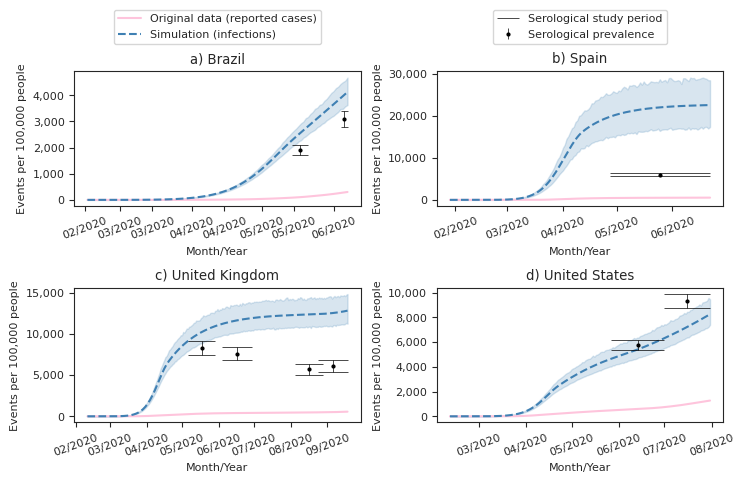

In [58]:
mask_date = mdates.DateFormatter('%m/%Y')
line_styles = ['-', '--', ':', '-.', '-']
plt.rc('font', size=8)
sns.set_style("ticks")
sns.set_palette(util.get_default_colors_categorical_seaborn())

subplots = ['a', 'b', 'c', 'd']

fig, ax = plt.subplots(2, 2, figsize=(util.centimeter_to_inch(19.05), util.centimeter_to_inch(12.93)), sharex=False)

for i, country in enumerate(['Brazil', 'Spain', 'United Kingdom', 'United States']):
    df_prevalence_analysis_real_country = df_prevalence_analysis_real[df_prevalence_analysis_real.country == country]
    df_prevalence_analysis_simulation_country = df_prevalence_analysis_simulation[df_prevalence_analysis_simulation.country == country]

    sns.lineplot(data=df_prevalence_analysis_real_country, x='date', y='rate_new_cases_moving_average', label='Original data (reported cases)', legend=(i==0), linestyle=line_styles[0], ax=ax.flatten()[i])
    sns.lineplot(data=df_prevalence_analysis_simulation_country, x='date', y='I_accumulated', label='Simulation (infections)', legend=(i==0), linestyle=line_styles[1], ax=ax.flatten()[i], errorbar=('ci', 95))
    
    df_prevalence_studies_country = df_prevalence_studies[df_prevalence_studies.country == country].reset_index(drop=True)
    
    for index, prevalence_study in df_prevalence_studies_country.iterrows():
        reference_values = prevalence_study.prevalence_per_100k
        reference_ci_lower = prevalence_study.prevalence_per_100k_lower
        reference_ci_upper = prevalence_study.prevalence_per_100k_upper
        reference_start = prevalence_study.begin
        reference_end = prevalence_study.end
        quantity_days = (reference_end - reference_start).days
        reference_middle = reference_start + pd.DateOffset(days=quantity_days/2)
        if (index == 0) & (i == 1):
            label_prevalence =  'Serological prevalence'
            label_period = 'Serological study period' 
        else:
            label_prevalence = None
            label_period = None
        ax.flatten()[i].errorbar(x=reference_middle, y=reference_values, yerr=[[reference_values - reference_ci_lower], [reference_ci_upper - reference_values]], fmt='o', color='black', markersize=2, label=label_prevalence,  linewidth=0.5)
        ax.flatten()[i].hlines(y=reference_ci_lower, xmin=reference_start, xmax=reference_end, color='black', linestyle='-', label=label_period, linewidth=0.5)
        ax.flatten()[i].hlines(y=reference_ci_upper, xmin=reference_start, xmax=reference_end, color='black', linestyle='-',  linewidth=0.5)
    
    ax.flatten()[i].set_xlabel('Month/Year')
    ax.flatten()[i].xaxis.set_major_formatter(mask_date)
    ax.flatten()[i].tick_params(axis='x', labelrotation=20)
    ax.flatten()[i].set_ylabel('Events per 100,000 people')
    ax.flatten()[i].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.flatten()[i].set_title(subplots[i] + ') ' + country)
    if i == 0:         
        ax.flatten()[i].legend(ncols=1, loc='upper center', bbox_to_anchor=(0.5, 1.5))
    elif i == 1:
        handles, labels = ax.flatten()[i].get_legend_handles_labels()
        ax.flatten()[i].legend(handles[2:], labels[2:], ncols=1, loc='upper center', bbox_to_anchor=(0.5, 1.5))

fig.tight_layout()
filename = 'images/prevalence_analysis'
plt.savefig(filename+'.pdf', bbox_inches="tight")
plt.savefig(filename+'.tiff', format='tiff', dpi=300, transparent=False, bbox_inches='tight')
img = Image.open(filename+".tiff")
img.save(filename+"_compressed.tiff", compression="tiff_lzw")
plt.show()